In [3]:
import sys
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
my_libs_dir = '../'
if not my_libs_dir in sys.path:
    sys.path.append(my_libs_dir)  # add the path to my_lib directory 

# The following lines are needed to auto-reload my library file
# Without these lines, my library file is read only once and
# modifications of my library file are not reflected.
%load_ext autoreload
%autoreload 1
%aimport my_libs.linear_reg
# import from my library file
from my_libs.linear_reg import step_aic_forward, calc_vifs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%config InlineBackend.figure_formats = {'png', 'retina'} #high-reso images
font = {'family' : 'Yu Mincho'}
matplotlib.rc('font', **font)

# To show all rows and columns in the results 
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [8]:
csv_in = 'winequality-red_modified-utf8.txt'
df_all = pd.read_csv(csv_in, delimiter='\s+', skiprows=13, header=0)
# no header in csv, so set columns explicitly
# df_all.columns = ['sex', 'len', 'd', 'h', 'w_all', 'w_meat', 'w_gut', 'w_shell', 'ring']
print(df_all.shape)
print(df_all.info())
display(df_all.head())

(1599, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1598 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1597 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,NaN,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,NaN,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,NaN,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [9]:
df_all = df_all.dropna().reset_index(drop=True)
print(df_all.shape)
display(df_all.head())

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,NaN,3.20,0.68,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,NaN,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,NaN,11.0,34.0,0.9978,3.51,0.56,9.4,5


(1596, 12)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
2,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
3,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
4,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7


In [10]:
X_all = df_all.loc[:, 'fixed_acidity':'alcohol']  # explanatory variables
y = df_all['quality']  # objective variable
print('X_all:', X_all.shape)
print('y:', y.shape)

X_all: (1596, 11)
y: (1596,)


In [11]:
corr_all = X_all.corr(method='pearson')
display(corr_all)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
fixed_acidity,1.000000,-0.254796,0.671376,0.115231,0.094037,-0.154094,-0.113752,0.668356,-0.683007,0.183527,-0.061580
volatile_acidity,-0.254796,1.000000,-0.550864,0.001749,0.061071,-0.011231,0.076463,0.022282,0.234924,-0.261792,-0.202022
citric_acid,0.671376,-0.550864,1.000000,0.143933,0.204452,-0.060859,0.035440,0.365623,-0.542063,0.313457,0.109363
residual_sugar,0.115231,0.001749,0.143933,1.000000,0.055469,0.187006,0.203091,0.355759,-0.085640,0.005230,0.041679
chlorides,0.094037,0.061071,0.204452,0.055469,1.000000,0.005389,0.047337,0.200882,-0.265166,0.371164,-0.221426
free_sulfur_dioxide,-0.154094,-0.011231,-0.060859,0.187006,0.005389,1.000000,0.667541,-0.021855,0.071304,0.051475,-0.069386
total_sulfur_dioxide,-0.113752,0.076463,0.035440,0.203091,0.047337,0.667541,1.000000,0.071252,-0.065735,0.042895,-0.205651
density,0.668356,0.022282,0.365623,0.355759,0.200882,-0.021855,0.071252,1.000000,-0.342146,0.148960,-0.495957
pH,-0.683007,0.234924,-0.542063,-0.085640,-0.265166,0.071304,-0.065735,-0.342146,1.000000,-0.196633,0.206091
sulphates,0.183527,-0.261792,0.313457,0.005230,0.371164,0.051475,0.042895,0.148960,-0.196633,1.000000,0.093188


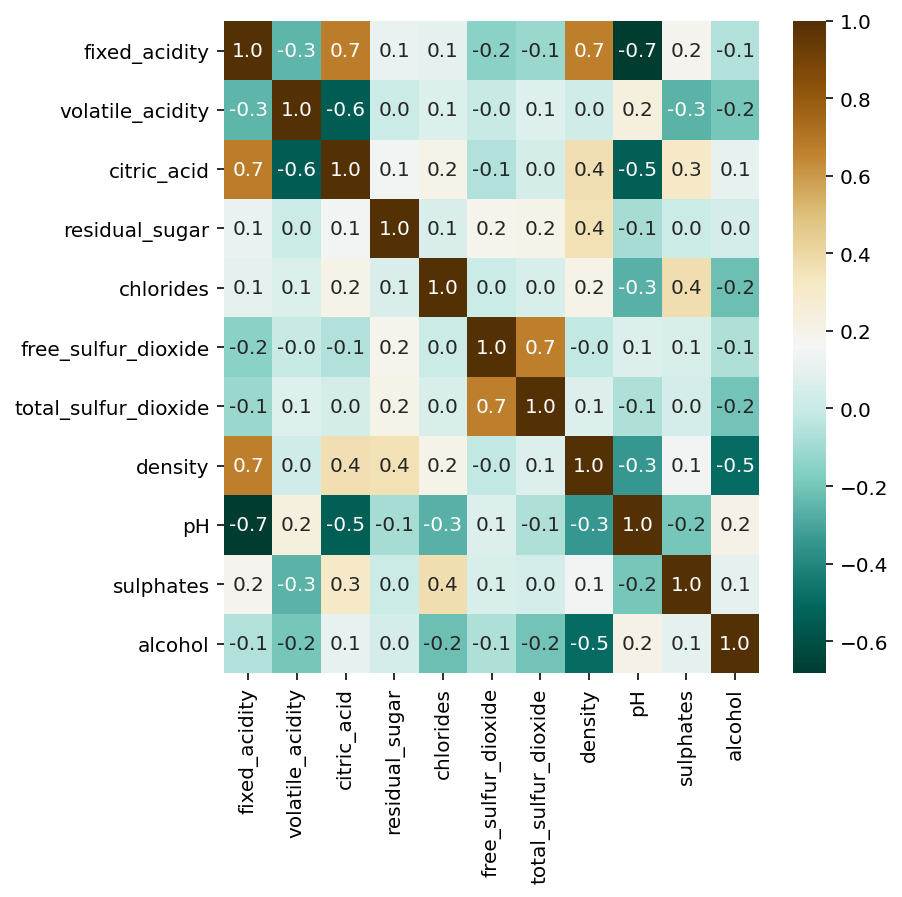

In [26]:
plt.figure(figsize=(6,6))
sns.heatmap(corr_all,annot=True,fmt='.1f',cmap='BrBG_r')
plt.show()

In [24]:
X_all_c = sm.add_constant(X_all)
model = sm.OLS(y, X_all_c)
results = model.fit()
print('R2:', results.rsquared)
print('Adj R2:', results.rsquared_adj)
print('p-values (F-statistic)', results.f_pvalue)
print(results.summary())

R2: 0.36008321392086784
Adj R2: 0.3556393473508739
p-values (F-statistic) 6.168748635716057e-145
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.03
Date:                Sun, 02 May 2021   Prob (F-statistic):          6.17e-145
Time:                        16:40:09   Log-Likelihood:                -1567.6
No. Observations:                1596   AIC:                             3159.
Df Residuals:                    1584   BIC:                             3224.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [28]:
X_scaled = preprocessing.scale(X_all)
y_scaled = preprocessing.scale(y)
model = sm.OLS(y_scaled, X_scaled)
results = model.fit()
print('R2:', results.rsquared)
print('Adj R2:', results.rsquared_adj)
print('p-values (F-statistic)', results.f_pvalue)
print(results.summary())

R2: 0.36008321392086784
Adj R2: 0.3556421510521799
p-values (F-statistic) 4.948632336168239e-145
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.360
Model:                            OLS   Adj. R-squared (uncentered):              0.356
Method:                 Least Squares   F-statistic:                              81.08
Date:                Sun, 02 May 2021   Prob (F-statistic):                   4.95e-145
Time:                        16:46:22   Log-Likelihood:                         -1908.4
No. Observations:                1596   AIC:                                      3839.
Df Residuals:                    1585   BIC:                                      3898.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef  

In [30]:
# NOTE: make DataFrames corresponding to X_scaled and y_scaled.
dfX_scaled = pd.DataFrame(X_scaled, columns=X_all.columns)
dfy_scaled = pd.Series(y_scaled, name=y.name)
exog = list(dfX_scaled.columns)  # Initial set = all explanatory variables
endog = [dfy_scaled.name]  # Objective variables
df_scaled = pd.concat([dfX_scaled, dfy_scaled], axis=1)
results_aic=step_aic_forward(smf.ols, exog, endog, data=df_scaled)

AIC: 4531.252, formula: quality ~ 1
AIC: 4508.780, formula: quality ~ fixed_acidity
AIC: 4477.538, formula: quality ~ total_sulfur_dioxide
AIC: 4450.253, formula: quality ~ citric_acid
AIC: 4270.337, formula: quality ~ volatile_acidity
AIC: 4123.148, formula: quality ~ alcohol
AIC: 4428.999, formula: quality ~ sulphates
AIC: 4483.646, formula: quality ~ density
AIC: 4529.172, formula: quality ~ free_sulfur_dioxide
AIC: 4528.011, formula: quality ~ pH
AIC: 4506.508, formula: quality ~ chlorides
AIC: 4532.954, formula: quality ~ residual_sugar
AIC: 4076.123, formula: quality ~ alcohol + fixed_acidity
AIC: 4108.632, formula: quality ~ alcohol + total_sulfur_dioxide
AIC: 4061.342, formula: quality ~ alcohol + citric_acid
AIC: 3928.074, formula: quality ~ alcohol + volatile_acidity
AIC: 4033.266, formula: quality ~ alcohol + sulphates
AIC: 4114.882, formula: quality ~ alcohol + density
AIC: 4124.514, formula: quality ~ alcohol + free_sulfur_dioxide
AIC: 4072.263, formula: quality ~ alcohol 

In [32]:
print(results_aic.aic)
print(results_aic.model.exog_names)
print(results_aic.model.endog_names)

3835.4763012244853
['Intercept', 'alcohol', 'volatile_acidity', 'sulphates', 'total_sulfur_dioxide', 'chlorides', 'pH', 'free_sulfur_dioxide']
quality


In [35]:
endogs = results_aic.model.endog_names
exogs = results_aic.model.exog_names.copy()
exogs.remove('Intercept')
#print(exogs)  # debug
X_c = sm.add_constant(X_all[exogs])
vifs = calc_vifs(X_c, y)
display(vifs)

,VIF
const,618.539992
alcohol,1.220248
volatile_acidity,1.242579
sulphates,1.322258
total_sulfur_dioxide,1.943518
chlorides,1.333407
pH,1.255038
free_sulfur_dioxide,1.882888


In [36]:
X_final_scaled = dfX_scaled[exogs]
model_final_scaled = sm.OLS(y_scaled, X_final_scaled)
results_final_scaled = model_final_scaled.fit()
print(results_final_scaled.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.359
Model:                            OLS   Adj. R-squared (uncentered):              0.356
Method:                 Least Squares   F-statistic:                              127.1
Date:                Sun, 02 May 2021   Prob (F-statistic):                   1.48e-148
Time:                        16:54:53   Log-Likelihood:                         -1909.7
No. Observations:                1596   AIC:                                      3833.
Df Residuals:                    1589   BIC:                                      3871.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [37]:
print(results_final_scaled.params)

alcohol                 0.381874
volatile_acidity       -0.223534
sulphates               0.185601
total_sulfur_dioxide   -0.142075
chlorides              -0.117664
pH                     -0.092192
free_sulfur_dioxide     0.065957
dtype: float64
